# Проверка результатов А/В-теста рекомендательной системы

**Описание исследования**

Заказчик планирует внести изменения в рекомендательную систему. Чтобы проверить, что новая система действительно положительно влияет на прохождение воронки продаж, был проведен А/В-тест.

Ожидается, что в экспериментальной группе конверсия на каждом этапе воронки вырастет как минимум на 10%.


**Цель работы**

- Оценить корректность проведения теста и соответствие ТЗ;
- Проанализировать результаты теста.

**Техническое задание к А/В-тесту**

- Название теста: `recommender_system_test`
- Группы: 
    - А — контрольная
    - B — новая платёжная воронка
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04
- Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
- Ожидаемое количество участников теста: 6000
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%
    - конверсии в просмотр карточек товаров — событие `product_page`
    - просмотры корзины — `product_cart`
    - покупки — `purchase`

**План работы**

1. [Предобработка данных](#cleaning)
2. [Проверка корректности проведения теста](#soundcheck)
- Соответствие ТЗ
- Время проведения
- Пересечения с другими тестами
- Распределение по группам
3. [Исследовательский анализ данных](#eda)
- Число событий на пользователя по группам
- Число событий по дням
- Конверсия на этапах воронки
4. [Проверка результатов А/В-теста](#no_use)
- Результаты группы В
- Статистический тест на равенство долей
5. [Общий вывод](#gen_concl)

**Данные**

- `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;
- `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года;
- `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- `final_ab_participants.csv` — таблица участников тестов.

## Подготовка данных

Загрузим нужные библиотеки и определим функции для предобработки.

In [610]:
# импорт библиотек

# стандартные
import datetime as dt
from datetime import timedelta
import warnings

# панды и визуализация
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# математика 
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [611]:
# функции для предобработки

def preview(df):
    '''Выводит основную информацию о датафрейме, случайные 10 строк и количество полных дубликатов.'''
    print(df.info())
    display(df.sample(10, random_state=77))
    print(f'\nПолностью дублирующихся строк: {df.duplicated().sum()}')
    
def na_detector(df):
    '''Возвращает число и процент пропусков по столбцам (только те столбцы, в которых есть пропуски).'''
    na_cols = pd.DataFrame(
        {'Число_пропусков' : df.isna().sum(), 
         'Процент' : round(df.isna().mean()*100, 1)}
        ).query('Число_пропусков > 0')
    return na_cols

def na_pct_by_col(df, grouping_col='col'):
    '''Группирует данные по указанному столбцу и рассчитывает процент пропусков для каждой группы 
    для всех признаков, где есть пропущенные значения. Использует функцию na_detector.'''
    na_cols = na_detector(df)
    na_grouped_dict = {}
    if grouping_col == 'col':
        print('Не указан столбец для группировки.')
    else:
        for col in na_cols.index:
            na_grouped_dict[col] = (
                df.groupby(grouping_col).apply(lambda x: round(x[col].isna().mean()*100, 1))
            )
        na_grouped = pd.DataFrame(na_grouped_dict)
        return na_grouped

### Загрузка и просмотр исходных данных

Загрузим 4 датасета в соответствующие переменные и просмотрим основную информацию о каждом.

In [612]:
path = 'https://code.s3.yandex.net/datasets/'

try:
    ab_raw = pd.read_csv(path + 'final_ab_participants.csv')
    users_raw = pd.read_csv(path + 'final_ab_new_users.csv')
    events_raw = pd.read_csv(path + 'final_ab_events.csv')
    marketing_events_raw = pd.read_csv(path + 'ab_project_marketing_events.csv')
except:
    print('Проверить путь и/или имя файла.')

Первый датасет – участники теста.

In [613]:
preview(ab_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


,user_id,group,ab_test
9642,7448A9A617B6A55D,B,interface_eu_test
1024,B20F60904CDDFA77,A,recommender_system_test
1681,1675B921AC721DBE,A,recommender_system_test
2059,AD8FDC549AE56322,B,recommender_system_test
12507,29712D184A6377C0,A,interface_eu_test
6541,174AC9628248653E,A,recommender_system_test
4158,8F982481F1B37414,B,recommender_system_test
17809,DE288F045E8FBF5C,A,interface_eu_test
13889,D755F72C453BF6A7,B,interface_eu_test
16034,5BCF882D90F5BD91,B,interface_eu_test



Полностью дублирующихся строк: 0


Имеем 18268 наблюдений, но информация об участниках сразу двух тестов. Нам нужен `recommender_system_test`. На этапе предобработки важно проверить, что каждый пользователь участвовал только в одном тесте.

Второй датасет – пользователи, зарегистрировавшиеся за две недели с 7 до 21 декабря 2020 года. Из них выбирались участники А/В-теста.

In [614]:
preview(users_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
9634,BE75BA229F839D87,2020-12-14,APAC,iPhone
22846,BDC1CDF48F4E9E62,2020-12-15,EU,Android
34783,E323B7C38A99C320,2020-12-10,EU,Android
57470,34D31B1BC509F5AA,2020-12-20,EU,Android
58928,55144501EFCDA38E,2020-12-20,EU,Android
22168,1CCF3D75719B89A1,2020-12-15,APAC,PC
59748,7C7A1ED64E9EBD13,2020-12-20,CIS,Android
38353,E6CE0E097E57AD2C,2020-12-17,N.America,Android
6716,A443BF83E7D75969,2020-12-14,EU,PC
21545,C6FCCECD4166677B,2020-12-15,EU,Mac



Полностью дублирующихся строк: 0


За две недели привлекли 61733 новых пользователей. В столбце с датой регистрации нужно изменить тип данных.

Имеем пользователей из нескольких регионов. Также есть разбивка по устройствам первого входа.

Третий датасет – события, которые совершали новые пользователи в период с 7 декабря 2020 по 4 января 2021 года (четыре недели).

In [615]:
preview(events_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
31338,A04A7C6990938934,2020-12-19 11:10:56,purchase,4.99
434932,A0B865AD5BA42A57,2020-12-28 01:55:42,login,NaN
150304,52817580004E4389,2020-12-13 14:44:28,product_page,NaN
190592,0BAEE1822A552231,2020-12-19 07:16:27,product_page,NaN
316456,1CF7598BEF22D91D,2020-12-16 02:28:36,login,NaN
38776,64B5CEB2FDC0ADA6,2020-12-21 23:56:32,purchase,4.99
40895,F386843B0205EA26,2020-12-21 08:08:54,purchase,9.99
42152,7C6F25E8F9096A75,2020-12-21 00:55:43,purchase,4.99
294461,F2501C92AD504A55,2020-12-13 07:47:58,login,NaN
234266,797FCDC85F693042,2020-12-25 06:20:44,product_page,NaN



Полностью дублирующихся строк: 0


За месяц новые пользователи совершили более 440 тыс. событий. 

Есть пропущенные значения в столбце `details` – столбец похож на стоимость покупки, которая заполняется только если пользователь дошел до этого этапа воронки. Если все значения для события `purchase` заполнены, то пропуски не представляют проблемы. Проверим на этапе предобработки.

В столбце с датой и временем события нужно изменить тип данных.

Последний, четвертый датасет – календарь маркетинговых событий на 2020 год. Корректно проведенный тест не должен совпадать по времени с событиями, на протяжении которых поведение пользователей отличается от обычного.

In [616]:
preview(marketing_events_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10



Полностью дублирующихся строк: 0


Всего за 2020 год провели 14 маркетинговых событий. Есть даты начала и конца проведения кампании, эти столбцы тоже нужно привести к подходящему типу данных.

**Выводы по исходным данным**

Качество данных хорошее. 

На этапе предобработки:
- Изменить тип данных в столбцах даты и времени;
- Проверить корректность пропущенных значений стоимости покупки (столбец `details` в датасете `events`).

<a id='cleaning'></a>
### Предобработка данных

Предобработку выполним в 4 этапа:
- Пропущенные значения;
- Неявные дубликаты;
- Выбросы;
- Корректность заполнения данных.

#### Пропущенные значения

Пропуски есть только в одном столбце – `details` в датасете `events`.

Рассчитаем их количество.

In [617]:
na_detector(events_raw)

,Число_пропусков,Процент
details,377577,85.8


Проверим предположение о том, что значения заполнены только для типа события `purchase`, покупка. Сгруппируем данные по событиям и рассчитаем процент пропусков в столбце.

In [618]:
na_pct_by_col(events_raw, 'event_name')

,details
event_name,
login,100.0
product_cart,100.0
product_page,100.0
purchase,0.0


С данными все в порядке. Столбец `details` содержит стоимость покупки и заполняется только для соответствующего события.

#### Неявные дубликаты

Найдем строки, у которых совпадают ключевые признаки:
- Уникальный идентификатор в датасетах с участниками теста и всеми новыми пользователями;
- Уникальный идентификатор в комбинации с датой и временем для датасета событий.

Проверим `user_id` на уникальность.

In [619]:
users_raw['user_id'].duplicated().sum()

0

Записи о новых пользователях за период уникальны, все хорошо. Проверим участников теста.

In [620]:
ab_raw['user_id'].duplicated().sum()

1602

В датасете с участниками тестов 1602 пользователя дублируются. Посмотрим на эти строки.

In [621]:
ab_raw[ab_raw['user_id'].duplicated(keep=False)].sort_values(by='user_id').head(10)

,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
3156,003B6786B4FF5B03,A,recommender_system_test
4768,0082295A41A867B5,A,recommender_system_test
14161,0082295A41A867B5,B,interface_eu_test
15562,00E68F103C66C1F7,B,interface_eu_test
4074,00E68F103C66C1F7,A,recommender_system_test


Первые 5 пользователей, похоже, дублируются из-за участия в двух тестах сразу. Проверим, верно ли это для всех дублей.

In [622]:
ab_raw[ab_raw['user_id'].duplicated(keep=False)].groupby('ab_test').size()

ab_test
interface_eu_test          1602
recommender_system_test    1602
dtype: int64

Дубли равномерно распределились по тестам.

Посмотрим, какой процент из всех записей об участниках занимают дубликаты. 

In [623]:
round(
    len(ab_raw[ab_raw['user_id'].duplicated(keep=False)])
    /
    len(ab_raw) * 100,
1)

17.5

17.5% записей об участниках теста – дубли.

Попадание клиентов в два теста чревато искажением результатов. Если в одном тесте участник попал в экспериментальную группу В, то на его поведение повлияют тестируемые изменения. Тогда в другом тесте он не может быть ни в контрольной группе (поведение изменено), ни в экспериментальной (на поведение влияют сразу два разных изменения).

Таких участников принимать к анализу нельзя. Рассчитаем, какую долю пользователей в тесте `recommender_system_test` мы потеряем, если исключим попавших в оба теста.

In [624]:
((
    ab_raw['user_id'].duplicated().sum()
    /
    len(ab_raw.query('ab_test == "recommender_system_test"'))
)*100).round(1)

23.9

24% данных – почти четверть участников – следовало бы исключить. Ожидаемое число участников теста по ТЗ составляет 6 тысяч. Проверим, будет ли это требование удовлетворено при удалении дубликатов.

In [625]:
(
    len(ab_raw.query('ab_test == "recommender_system_test"'))
    -
    ab_raw['user_id'].duplicated().sum()
)

5099

В тесте останется лишь 5 тысяч участников. Посмотрим соотношение размеров групп А и В в обоих тестах.

In [626]:
ab_raw.pivot_table(index='ab_test', columns='group', aggfunc={'user_id':'nunique'})

user_id      
group                         A     B
ab_test                              
interface_eu_test          5831  5736
recommender_system_test    3824  2877

В параллельно проходящем тесте `interface_eu_test` распределение по группам намного более равномерное. Участников там тоже больше.

Чтобы выполнить требование о количестве участников, можно оставить в данных тех пользователей, которые в конкурирующем тесте попали в контрольную группу А, так как на их поведение не повлияли никакие изменения. Юзеров из группы В второго теста брать нельзя.

Рассчитаем, какой процент участников нашего теста мы потеряем при исключении пользователей, попавших во втором тесте в группу В.

In [627]:
ab_duplicates = ab_raw.query('user_id.duplicated(keep=False)')

print('Процент экспериментальных юзеров конкурирующего теста:', 
      '{:.1%}'.format
      (
          ab_duplicates.query('ab_test == "interface_eu_test" & group == "B"').shape[0]
          /
          len(ab_raw.query('ab_test == "recommender_system_test"'))
      )
     )
print('Число участников теста recommender_system_test при их исключении:', 
     (
         len(ab_raw.query('ab_test == "recommender_system_test"'))
         -
         ab_duplicates.query('ab_test == "interface_eu_test" & group == "B"').shape[0]
     ))

Процент экспериментальных юзеров конкурирующего теста: 11.7%
Число участников теста recommender_system_test при их исключении: 5918


Число участников нашего теста почти достигает требуемого. Примем решение исключить только пользователей из группы В второго теста, чтобы данных осталось достаточно. Частичное исключение участников теста не оптимально, доверие к результатам снижается.

In [628]:
# сохраним идентификаторы пользователей для исключения
dupl_to_drop_uid = ab_duplicates.query('ab_test == "interface_eu_test" & group == "B"')['user_id'].unique()

In [629]:
print('Число исключенных уникальных пользователей:', len(dupl_to_drop_uid))
print('Исключено наблюдений:', ab_raw.query('user_id.isin(@dupl_to_drop_uid)').shape[0])
print('Процент от всех данных:', '{:.1%}'.format(
    ab_raw.query('user_id.isin(@dupl_to_drop_uid)').shape[0]
    /
    len(ab_raw)))
rstest_smpl_size = ab_raw.query('ab_test == "recommender_system_test"').shape[0]
print('Процент от целевого теста:', '{:.1%}'.format(len(dupl_to_drop_uid)/rstest_smpl_size))

Число исключенных уникальных пользователей: 783
Исключено наблюдений: 1566
Процент от всех данных: 8.6%
Процент от целевого теста: 11.7%


Проверим на дубликаты датасет событий. Сгруппируем действия пользователей по идентификатору и точному времени события.

In [630]:
events_raw[
    events_raw[['user_id', 'event_dt']].duplicated(keep=False)
].sort_values(by=['user_id', 'event_dt'])

,user_id,event_dt,event_name,details
15989,000199F1887AE5E6,2020-12-14 09:56:09,purchase,4.99
157324,000199F1887AE5E6,2020-12-14 09:56:09,product_page,NaN
299212,000199F1887AE5E6,2020-12-14 09:56:09,login,NaN
19145,000199F1887AE5E6,2020-12-15 07:22:56,purchase,4.99
81751,000199F1887AE5E6,2020-12-15 07:22:56,product_cart,NaN
...,...,...,...,...
385602,FFFFE36C0F6E92DF,2020-12-22 11:38:57,login,NaN
222000,FFFFE36C0F6E92DF,2020-12-23 05:09:13,product_page,NaN
396849,FFFFE36C0F6E92DF,2020-12-23 05:09:13,login,NaN
119115,FFFFE36C0F6E92DF,2020-12-26 09:25:04,product_cart,NaN


Время событий указано до секунды. Некоторые пользователи, похоже, в течение секунды успевают пройти всю воронку событий от входа до покупки. Насколько такое возможно, неизвестно. Стоит проверить механизм регистрации времени события.

#### Выбросы

Выбросами в данных может считаться число событий на пользователя – есть ли клиенты, совершившие аномальное число покупок за период. Это не повлияет на результаты теста (нам важен факт перехода на следующий этап воронки). Построим гистограммы распределения по числу совершения каждого из событий одним и тем же пользователем.

In [631]:
sns.set_style('whitegrid')

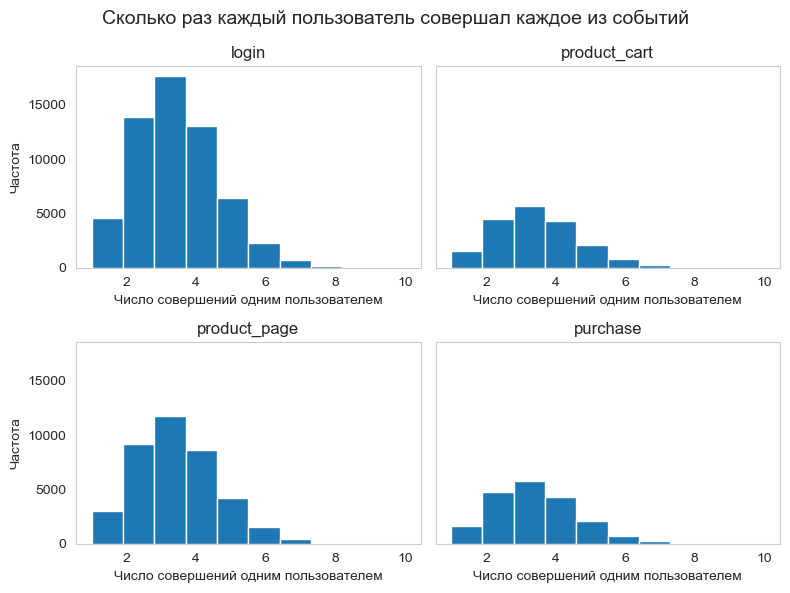

In [632]:
axes = events_raw.pivot_table(index='user_id', columns='event_name', values='event_dt',
                              aggfunc='count').hist(grid=False, sharey=True, figsize=(8,6));
plt.suptitle('Сколько раз каждый пользователь совершал каждое из событий', fontsize=14)
for i, ax in enumerate(axes.flatten()):
    ax.set_ylabel('Частота')
    ax.set_xlabel('Число совершений одним пользователем')
plt.tight_layout()

Распределение по числу событий подозрительно равномерное, однако аномальный значений нет.

Также проверим стоимость покупок (столбец `details` в данных о событиях).

In [633]:
events_raw['details'].describe()

count    62740.000000
mean        23.877631
std         72.180465
min          4.990000
25%          4.990000
50%          4.990000
75%          9.990000
max        499.990000
Name: details, dtype: float64

Минимальная сумма покупки – 4.99, она же медианная, но есть покупка стоимостью почти в 500 у.е.

Информация о цене покупки не является метрикой, которую проверяем в этом тесте, поэтому оставим дорогие покупки в данных.

#### Корректность заполнения данных

Проверим уникальные значения `region` и `device` в датасете с новыми пользователями.

In [634]:
print('region:', list(users_raw['region'].unique()))
print('device:', list(users_raw['device'].unique()))

region: ['EU', 'N.America', 'APAC', 'CIS']
device: ['PC', 'Android', 'iPhone', 'Mac']


Со значениями этих столбцов все в порядке.

### Выводы и внесение изменений

**Выводы по предобработке данных** 

Качество данных хорошее.

По результатам предобработки в данные внесены изменения:
- Столбцы с датой и временем переведем в тип `datetime`;
- Исключим пользователей, которые участвовали в двух А/В-тестах одновременно и в конкурирующем попали в группу В;
    - Из датасета с участниками теста (таблица `ab`) – 9%;
    - Из целевого теста – 12%.

In [635]:
# сохраним измененные данные в новых переменных
ab = ab_raw.copy()
users = users_raw.copy()
events = events_raw.copy()
marketing_events = marketing_events_raw.copy()

In [636]:
# преобразуем типы данных в столбцах даты и времени
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [637]:
# исключим участников в группе В конкурирующего теста
ab = ab.query('~user_id.isin(@dupl_to_drop_uid)')
# оставим в таблице только нужный нам тест
ab = ab.query('ab_test == "recommender_system_test"').drop('ab_test', axis=1)

Также создадим новую таблицу, в которой объединим данные о событиях и пользователях для тех, кто участвовал в тесте. Это поможет легко делить события по группам.

In [638]:
# объединим два датасета – о событиях и пользователях
df = ab.merge(events, on='user_id', how='left', validate='one_to_many')
df.rename(columns={'details':'price'}, inplace=True)
df = df.merge(users[['user_id', 'first_date', 'region']], on='user_id', how='left')

In [639]:
preview(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24516 entries, 0 to 24515
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24516 non-null  object        
 1   group       24516 non-null  object        
 2   event_dt    21842 non-null  datetime64[ns]
 3   event_name  21842 non-null  object        
 4   price       2939 non-null   float64       
 5   first_date  24516 non-null  datetime64[ns]
 6   region      24516 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.5+ MB
None


,user_id,group,event_dt,event_name,price,first_date,region
15165,EA13A8207E2AEC0C,A,2020-12-15 11:22:54,product_cart,NaN,2020-12-15,EU
4792,60113D4208F4A6EA,A,2020-12-21 08:12:37,product_page,NaN,2020-12-20,EU
24321,9A249D543CF73E68,A,2020-12-29 15:40:17,purchase,4.99,2020-12-20,APAC
3911,08D42E112D1F4407,A,2020-12-14 21:17:09,purchase,4.99,2020-12-14,EU
15414,067D05BD30F04F2E,B,2020-12-07 17:05:56,product_page,NaN,2020-12-07,EU
13118,5AD6C5CA55F10640,A,2020-12-17 14:55:10,login,NaN,2020-12-17,EU
15649,943DC4BA8E315141,A,2020-12-16 19:45:33,login,NaN,2020-12-14,EU
13388,FF0CF3A2B430E000,A,2020-12-17 17:29:54,login,NaN,2020-12-15,EU
16740,6805058419CB4E55,A,2020-12-14 12:32:13,product_cart,NaN,2020-12-13,EU
4983,9999E0476CE6B08B,A,2020-12-23 20:59:44,purchase,4.99,2020-12-14,EU



Полностью дублирующихся строк: 0


Итого в тесте данные о 24516 событиях.

<a id='soundcheck'></a>
## Проверка корректности проведения теста

Критерии проверки:

- Временные диапазоны:
    - Период регистрации новых пользователей – с 7 по 21 декабря 2020; 
    - Период проведения теста – с 7 декабря 2020 по 4 января 2021; 
    - Одновременно с тестом не проходит маркетинговых активностей. 
- Формирование групп:
    - Группы похожего размера; 
    - Один пользователь не может быть в двух группах; 
    - Пользователь не участвует в других тестах; 
    - Из региона EU в тест должно быть отобрано 15% новых пользователей; 
    - Размер выборки около 6000.

### Временной период

Проверим временные периоды:
- Датасет новых пользователей `users` – с 7 до 21 декабря 2020 год;
- Датасет событий `events` – с 7 декабря 2020 по 4 января 2021 года.

In [640]:
print(f'Дата запуска: {users["first_date"].min().date()}')
print(f'Дата остановки набора новых пользователей: {users["first_date"].max().date()}\n')
print(f'Первое событие: {events["event_dt"].min().date()}')
print(f'Дата остановки: {events["event_dt"].max().date()}')

Дата запуска: 2020-12-07
Дата остановки набора новых пользователей: 2020-12-23

Первое событие: 2020-12-07
Дата остановки: 2020-12-30


Оба временных диапазона отличаются от заявленных:
- Набор новых пользователей шел на 2 дня дольше – до 23 декабря, а не до 21;
- Остановка теста, наоборот, произошла раньше – 30 декабря вместо 4 января.

Ограничим период набора пользователей до указанного в ТЗ – с 7 до 21 декабря 2020 включительно (15 дней). Пользователей, зарегистрировавшихся после 21 декабря, исключим.

In [641]:
df = df.query('first_date <= "2020-12-21"')

Также нужно ограничить события установленным ТЗ лайфтаймом – 14 дней после регистрации. Однако из-за ранней остановки теста пользователи, пришедшие 21 декабря, прожили только 9 дней (до 30 декабря). Если они не успели совершить целевое действие за этот срок, но совершили бы при более продолжительной фиксации событий, то их показатели снизят как общую конверсию, так и отдельные показатели последних когорт.

Посмотрим, сколько времени в среднем занимает путь от первого посещения до первой покупки.

In [642]:
purchase_dt = (
    df.query('event_name == "purchase"').groupby('user_id')
    .agg({'first_date':'min', 'event_dt':'min'})
)
purchase_dt['delta'] = purchase_dt['event_dt'] - purchase_dt['first_date']
purchase_dt['delta'].describe()[['min', '50%', '75%', 'max']]

min    0 days 00:01:52
50%    0 days 12:03:05
75%    0 days 18:14:40
max    6 days 23:09:45
Name: delta, dtype: object

Пользователи продвигаются по воронке очень быстро. В среднем от первого посещения до покупки проходит всего 12 часов. Минимальное значение – 2 часа, самый медлительный пользователь решался в течение почти недели.

Это значит, что нет смысла исключать пользователей, которые не дожили до 14-го лайфтайма. Конверсия в покупку не занимает больше недели и чаще всего происходит уже в день регистрации. 

Для чистоты эксперимента исключим события, совершенные каждым пользователем более чем через 14 дней после регистрации.

In [643]:
tdlt = timedelta(14)
df = df.query('(event_dt - first_date) <= @tdlt', engine='python')

Проверим, могли ли повлиять на активность маркетинговые события в компании. Найдем кампании, которые проводились в декабре 2020 и январе 2021.

In [644]:
marketing_events.query('start_dt >= "2020-11-25" & regions.str.contains("EU")').sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


В это время в целевом регионе проходили 2 компании:
- "Черная пятница", хотя и закончилась 1 декабря, тоже могла повлиять на поведение пользователей: до и после такого типа акций продажи обычно падают – люди откладывают покупку до скидок, а после менее охотно покупают то, что неделю назад продавалось намного дешевле. 
- Вторая акция посвящена рождественским и новогодним праздникам, началась 25 декабря.

Стоит помнить о том, что поведение пользователей в условиях праздников и акций отличается от обычного. Мы можем сравнить группы А и В между собой, но время проведения теста не позволяет делать выводов о динамике активности пользователей в целом. 

### Формирование групп

Критерии проверки:
- Аудитория теста по ТЗ – это 15% новых пользователей из региона EU;
- Один пользователь не может быть в обеих группах одновременно;
- Ожидаемое количество участников – 6000;
- Группы должны быть сопоставимы по размеру.

Посмотрим, все ли пользователи из нужного региона.

In [645]:
df['region'].value_counts()

EU           19849
N.America      815
APAC           225
CIS            196
Name: region, dtype: int64

В тест попали пользователи из других регионов. Это еще один серьезный недостаток качества проведения теста. Оставим в данных только участников из EU.

In [646]:
df = df.query('region == "EU"')
ab = ab.merge(users.query('region == "EU"'), on='user_id')

Далее рассчитаем, соответствует ли доля пользователей из EU требуемому уровню в 15%.

На этапе предобработки мы исключили из участников теста тех, кто также попал в другой А/В-тест, причем был в нем в экспериментальной группе. Требования к доле участников из EU и к отсутствию пересечений между тестами будем оценивать отдельно, поэтому для расчета возьмем исходные данные.

In [647]:
eu_users = (
    users.query('region == "EU" & first_date <= "2020-12-21"')
                .merge(ab_raw.query('ab_test == "recommender_system_test"'), 
                on='user_id', how='left')
)
print(f'Число попавших в тест из региона EU: {eu_users["ab_test"].count()/len(eu_users):.0%}')

Число попавших в тест из региона EU: 15%


Технически требование выполнено, но некоторые пользователи на этапе предобработки были исключены. Посчитаем, какая доля европейских пользователей осталась после исключения тех, кто одновременно попал в другой тест.

In [648]:
_ = len(ab)/len(users.query('region == "EU" & first_date <= "2020-12-21"'))
print(f'Число корректно попавших в тест из региона EU: {_:.0%}')

Число корректно попавших в тест из региона EU: 13%


В итоге аудитория получилась меньше нужных 15%.

Один и тот же пользователь не может быть в обеих группах одновременно. Проверим данные на наличие таких пересечений.

In [649]:
ab['user_id'].duplicated().sum()

0

Идентификаторы не повторяются. Пересечений между группами нет.

Теперь можно посчитать итоговое число участников теста.

In [650]:
print(f'Число участников теста: {len(ab)}')
print(f'От ожидаемого количества участников: {len(ab)/6000:.0%}')

Число участников теста: 5568
От ожидаемого количества участников: 93%


Размер выборки не дотягивает до 6 тысяч. Если требование не строгое, при недоборе в 7% его можно посчитать выполненным.

Также проверим группы на соразмерность: сравним число пользователей в группах А и В.

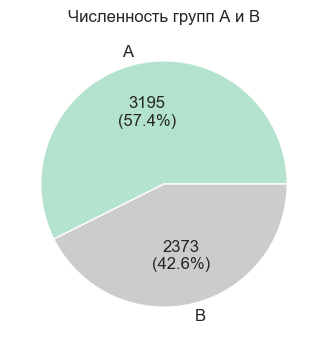

In [651]:
def pie_fmt(values):
    def fmt(pct):
        total = sum(values)
        value = int(round(pct*total/100.0))
        return '{v:d}\n({:.1f}%)'.format(pct, v=value)
    return fmt

plt.title('Численность групп А и В')
ab['group'].value_counts().plot.pie(autopct=pie_fmt(ab['group'].value_counts()), figsize=(4,4),
                                    textprops={'fontsize': 12}, cmap='Pastel2')
plt.ylabel(None);

In [652]:
size_a = ab.groupby('group').size()['A']
size_b = ab.groupby('group').size()['B']

print(f'Разница между размером групп: {abs(size_a-size_b) / ((size_a+size_b) / 2):.0%}')

Разница между размером групп: 30%


Группа В меньше почти на тысячу пользователей. Разница между группами существенная, это может исказить результаты теста. 

**Выводы по корректности проведения теста**

По качеству проведения А/В-теста выявлено множество серьезных недостатков:
- Некоторые пользователи участвовали еще в одном тесте в тот же период;
- В тест попали пользователи из регионов, не входящих в аудиторию;
- Группы различаются по размеру на 30%;
- Количество участников теста меньше ожидаемого на 7%;
- Набор пользователей продолжался на 2 дня дольше;
- Тест завершился на 5 дней раньше;
- Тест проводился по время рождественских и новогодних праздников, одновременно с маркетинговыми кампаниями под эти праздники.

Такое количество проблем не позволяет делать надежных выводов по тесту.

<a id='eda'></a>
## Исследовательский анализ данных

Для изучения данных рассмотрим некоторые показатели:
- Число событий:
    - На пользователя;
    - По датам;
- Воронка событий и конверсия на этапах.

### Распределение событий

Посмотрим, сколько событий в среднем совершали пользователи. Будем помнить, что во время теста проводились маркетинговые мероприятия – поведение пользователей, вероятно, отличалось от обычного. Можем сравнить группы А и В между собой, но не более.

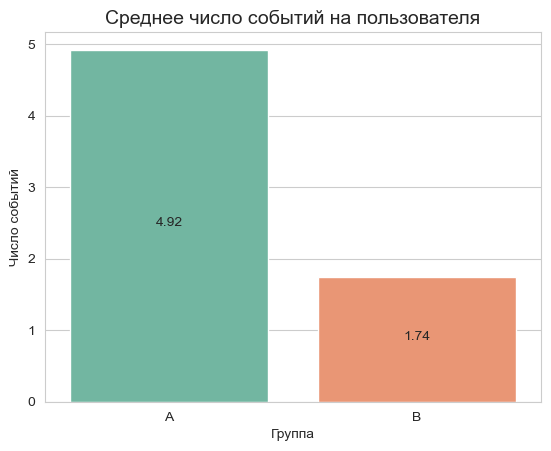

In [653]:
epu_a, epu_b = (
    len(df.query('group == "A"')) / len(ab.query('group == "A"')),
    len(df.query('group == "B"')) / len(ab.query('group == "B"'))
)

plt.title('Среднее число событий на пользователя', fontsize=14)
ax = sns.barplot(x=['A', 'B'], y=[epu_a, epu_b], palette='Set2');
for p in ax.patches:
    plt.text(p.get_x()+p.get_width()/2, p.get_height()/2,
             f'{p.get_height():.2f}', ha='center')
plt.ylabel('Число событий')
plt.xlabel('Группа');

Среднее количество событий на юзера в группе А в разы выше.

Посмотрим, как события распределяются по периоду. Построим график распределения числа событий на каждый день проведения теста в разбивке по группам.  

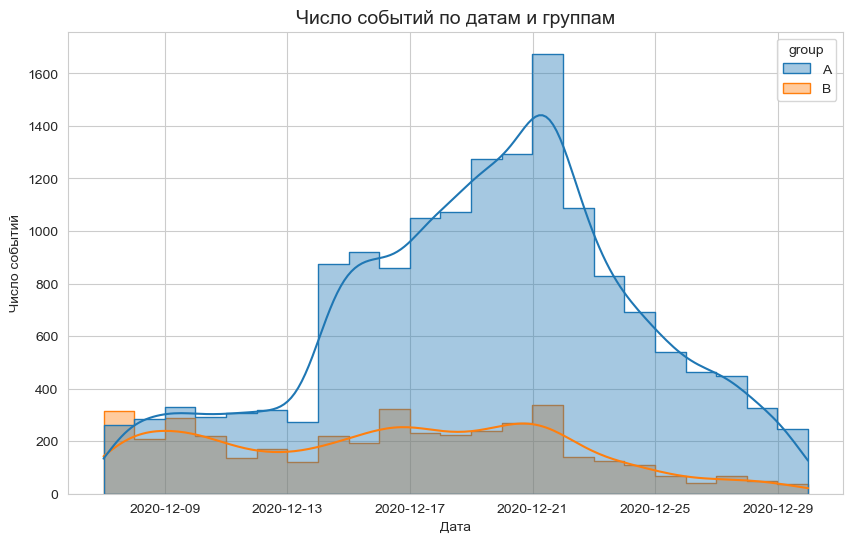

In [654]:
plt.figure(figsize=(10,6))
plt.title('Число событий по датам и группам', fontsize=14)
sns.histplot(data=df, x='event_dt', hue='group', kde=True, element='step', bins=23, alpha=0.4)
plt.xlabel('Дата')
plt.ylabel('Число событий');

На первый взгляд разница колоссальная, однако стоит помнить о разнице в размерах групп – группа А на 30% больше В, следовательно, событий также будет больше.

В начале периода (с 7 по 10 декабря) активность групп была примерно одинаковой и соотносилась с их численностью. В следующие три дня, с 11 по 13 декабря, контрольная группа выходит вперед и показывает уже двукратное преимущество. Затем происходит интересное: 14 декабря группа А резко уходит в отрыв, число событий в ней взлетает в несколько раз и до конца всего периода многократно превышает активность группы В. 

Попробуем определить причину резкого повышения активности в группе А 14 декабря. 

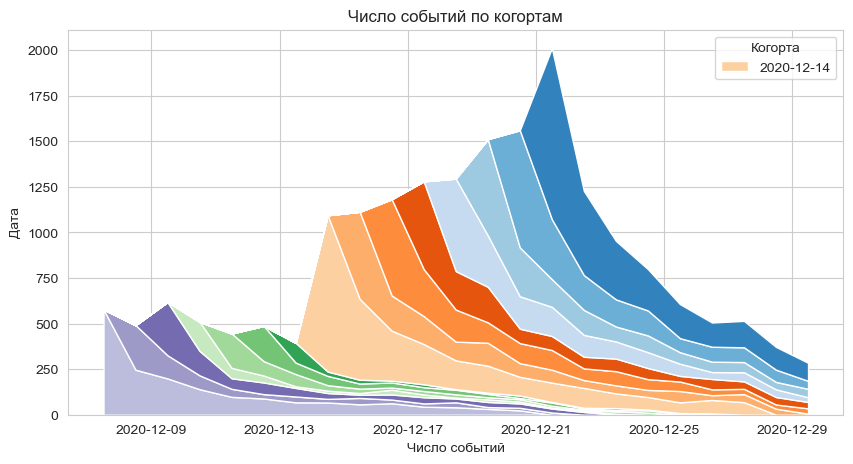

In [655]:
cohort_plot = df.sort_values(by='first_date', ascending=False)
# отобразим на легенде только нужную когорту через добавление префикса к остальным датам привлечения 
cohort_plot['first_date'] = cohort_plot['first_date'].dt.date.astype('str')
msk = cohort_plot['first_date'] == '2020-12-14'
cohort_plot['first_date'] = cohort_plot['first_date'].where(msk, 
                                                            '_' + cohort_plot['first_date'].astype('str'))

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)

    plt.figure(figsize=(10,5))
    plt.title('Число событий по когортам')
    ax = sns.histplot(data=cohort_plot,
                      x='event_dt', hue='first_date', element='poly', bins=23, alpha=1,
                      multiple='stack', palette='tab20c');
    ax.set(xlabel='Число событий', ylabel='Дата')
    ax.get_legend().set_title('Когорта')

В эту дату пришло аномально высокое число новых пользователей, однако скачок в числе событий наблюдаем только в группе А. Возможно ли, что в когорте 14 декабря произошел перекос в размерах групп, и в контрольную попало гораздо больше пользователей? Такого быть не должно, но в тесте уже обнаружены критичные ошибки, так что стоит проверить.

Посмотрим, как юзеры распределяются по группам за каждую дату привлечения.

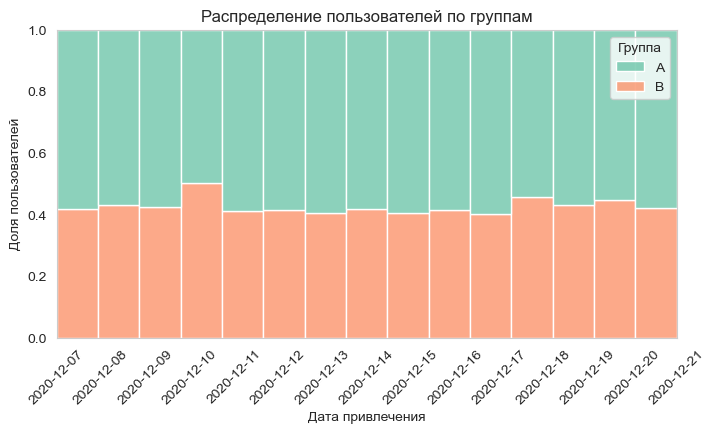

In [656]:
plt.figure(figsize=(8,4))
ax = sns.histplot(data=ab[['first_date', 'group']], x='first_date', hue='group', 
             bins=ab['first_date'].nunique(), multiple='fill', palette='Set2')
plt.grid(False)
plt.xticks(ticks=ab['first_date'].unique(), rotation=45)
ax.set(title='Распределение пользователей по группам', xlabel='Дата привлечения', ylabel='Доля пользователей')
ax.get_legend().set_title('Группа')

Пользователи распределяются по группам равномерно, в среднем около 60% попадают в группу А, и 14 декабря не исключение. Значит, дело не в числе юзеров – контрольная группа действительно становилась более активной.

Проверим вывод. Рассчитаем среднее число событий на пользователя за каждый день теста, чтобы сравнить активность групп с поправкой на их разные размеры.

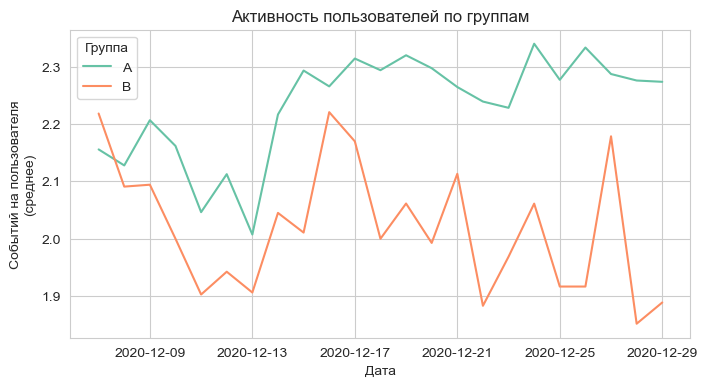

In [657]:
df['event_date'] = df['event_dt'].dt.date
ucnttest = df.pivot_table(index=['event_date', 'group'], values='user_id',
              aggfunc=lambda x: x.count()/x.nunique()).reset_index()

plt.figure(figsize=(8,4))
ax = sns.lineplot(data=ucnttest, x='event_date', y='user_id', hue='group', palette='Set2');
ax.set(title='Активность пользователей по группам', xlabel='Дата', ylabel='Событий на пользователя\n(среднее)')
ax.get_legend().set_title('Группа')

За исключением первого дня теста, пользователи группы А стабильно совершают больше событий. Более того, к концу периода активность контрольной группы пусть немного, но выросла, а в группе В только снизилась.

Несмотря на все недостатки в методике проведения теста, по количеству событий в группах можно заключить, что внесенные в рекомендательную систему изменения не оказывают положительного влияния на поведение пользователей.

### Воронка событий и конверсия

Выведем уникальные события и посчитаем, сколько раз они совершались всеми участниками теста.

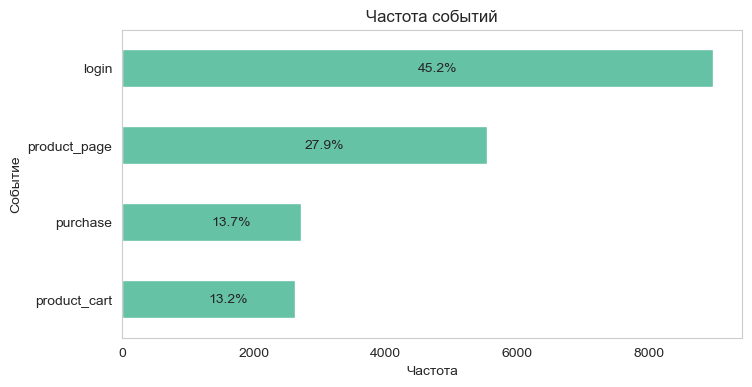

In [658]:
ax = (
    df['event_name'].value_counts().sort_values()
    .plot(kind='barh', figsize=(8,4), cmap='Set2', grid=False)
)
plt.title('Частота событий', fontsize=12)
plt.xlabel('Частота')
plt.ylabel('Событие');
for p in ax.patches:
    width = p.get_width()
    plt.text(p.get_width()/2, p.get_y()+p.get_height()/2,
             f'{width/len(df):.1%}',
             ha='left', va='center')

В воронке 4 события:
- `login` – вход;
- `products_page` – просмотр страницы товара;
- `products_cart` – просмотр корзины;
- `purchase` – покупка.

Интересно, что совершение покупки происходит чаще, чем просмотр корзины. 

Рассчитаем также, какое количество уникальных пользователей совершило каждое из событий.

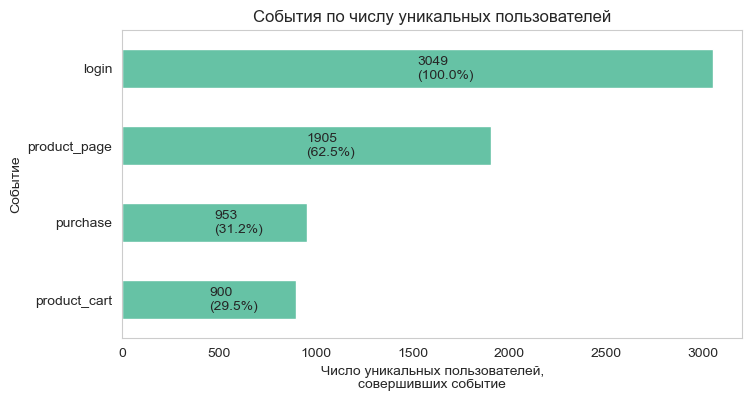

In [659]:
event_user_ucnt = df.groupby('event_name')['user_id'].nunique()
users_ucnt = df['user_id'].nunique()

ax = event_user_ucnt.sort_values().plot(kind='barh',figsize=(8,4), cmap='Set2', grid=False);

plt.title('События по числу уникальных пользователей')
plt.xlabel('Число уникальных пользователей,\nсовершивших событие')
plt.ylabel('Событие');
for p in ax.patches:
    width = p.get_width()
    plt.text(p.get_width()/2, p.get_y()+p.get_height()/2,
             f'{width}\n({width/users_ucnt:.1%})',
             ha='left', va='center')

Даже самое популярное событие совершили далеко не все пользователи (всего в тесте 5568 участников). Кажется, почти половина участников теста не проявила никакой активности.<br> 
*Также возможно, что авторизироваться для совершения покупки не обязательно.*

Покупки совершило большее число пользователей, чем просмотр/добавление в корзину. Далее будем считать этот шаг необязательным.

Построим воронку продаж и рассчитаем процент удержания на каждом этапе.

In [660]:
df['event_name_cat'] = pd.Categorical(df['event_name'], ['total', 'login', 'product_page', 'purchase'])

funnel = df.groupby('event_name_cat').agg({'user_id':'nunique'})
# добавим общее число участников теста
funnel.loc['total', 'user_id'] = len(ab)
funnel.sort_values(by='user_id', ascending=False, inplace=True)
# строим график
fig = px.funnel(funnel, title='Удержание на этапах воронки событий')
fig.update_traces(
    texttemplate='%{value}<br>От общего кол-ва: %{percentInitial}<br>С пред. шага: %{percentPrevious}',
    hovertemplate=None, hoverinfo='skip'
)
fig.update_layout(showlegend=False, yaxis_title='Этап воронки событий')

45% клиентов не совершили ни одного из действий, зато после авторизации конверсия неплохая – между входом и просмотром товара удержание 62%, от товара до покупки – 50%. 

Общая конверсия в покупку – 17%. Такой показатель практически во всех сферах считается отличным.

Построим воронку в разбивке по группам теста.

In [661]:
group_funnel = pd.DataFrame(df.groupby(['group', 'event_name_cat'])['user_id'].nunique())
group_funnel.loc[('A', 'total'), 'user_id'] = ab.query('group == "A"').shape[0]
group_funnel.loc[('B', 'total'), 'user_id'] = ab.query('group == "B"').shape[0]
group_funnel = group_funnel.reset_index().sort_values(by=['group', 'user_id'], ascending=False)

fig = px.funnel(group_funnel,
                x='user_id', y='event_name_cat', color='group',
                title='Удержание на этапах воронки событий по группам')
fig.update_traces(
    texttemplate='%{value}<br>%{percentInitial}',
    hovertemplate='От общего кол-ва: %{percentInitial}<br>С пред. шага: %{percentPrevious}'
)
fig.update_layout(yaxis_title='Этап воронки событий')

Общая конверсия в группах сильно различается: в группе А до покупки доходит 23% пользователей, а в группе В – 9%.

Заметно также сильное расхождение по удержанию на первом шаге воронки: в группе А авторизируется хотя бы 71% пользователей, тогда как в группе В всего 32%. 

Далее удержания по шагам выравниваются:
- От авторизации к просмотру товаров в группе А переходит 65% в группе В – 56%;
- От просмотра товаров к покупке конверсия в группе А составляет 50% в группе В – 51%;.

Итого в группе В по сравнению с контрольной:
- Намного реже авторизируются;
- Чуть менее охотно переходят к просмотру товаров;
- От просмотра товара до покупки переходит больше пользователей, но разница в 1%.

В целом удержание в группе А значительно лучше, однако снова наглядно видно разницу в размерах групп.

**Выводы по воронке событий**

В воронке 4 события:
- `login` – авторизация;
- `products_page` – просмотр страницы товара;
- `products_cart` – просмотр корзины;
    - Необязательный шаг, некоторые пользователи пропустили;
- `purchase` – покупка.

Авторизацию прошло 55% клиентов. Остальные либо обошлись без нее, либо не совершили ни одного из фиксируемых действий с момента первого посещения.



Общий процент удержания на каждом этапе воронки:
- От первого посещения до авторизации – 55%;
- От авторизации до просмотра товаров – 62%;
- От товаров до покупки – 50%.

Общая конверсия в покупку – 17%.

Удержание на этапах воронки по группам сильно различается:
- От первого посещения до авторизации:
    - А – **71%**;
    - В – **32%**;
- От авторизации до просмотра товаров:
    - А – 65%;
    - В – 56%;
- От товаров до покупки:
    - А – 50%;
    - В – 51%;
    
Конверсия в покупку по группам:
- А – **23%**;
- В – **9%**.

<a id='no_use'></a>
## Проверка результатов А/В-теста

Интерпретируем результаты теста и сравним конверсию на каждом шаге воронки в группах А и В. 

Важно помнить: не стоит стопроцентно полагаться на результаты в этом разделе, так как при проведении теста не выполнены базовые требования.

Еще раз перечислим критичные проблемы:
- Не выдержан временной период;
- Инструмент деления трафика работает некорректно (значительная часть пользователей одновременно участвовала в другом тестировании, группы разного размера, часть аудитории отобрана из нецелевых регионов);
- Исходя из общего качества теста допускается вероятность других ошибок, в том числе в фиксации пользовательский действий.

Сравним конверсию в группах А и В с помощью z-теста на пропорции.

Сформулируем нулевую и альтернативную гипотезы:

- H<sub>0</sub>: доли удержанных пользователей в группах равны
- H<sub>1</sub>: доли удержанных пользователей в группах не равны

Проверим разницу на каждом этапе воронки. Уровень статистической значимости – 5% с поправкой Бонферрони на множественные сравнения.

In [662]:
stat_values = (
    group_funnel.pivot(index='event_name_cat', columns='group', values='user_id')
    .sort_values(by='A', ascending=False)
)

n_tests = 3
alpha=0.05/n_tests

for step in stat_values.index[1:]:
    print('total -->', step, '\n')
    cnt, nobs = stat_values.loc[step, ['A', 'B']].values, stat_values.loc['total', ['A', 'B']].values
    z, p = proportions_ztest(cnt, nobs)
    print(cnt, nobs)
    print(f'Удержание в группе А: {cnt[0]/nobs[0]:.2%}')
    print(f'Удержание в группе В: {cnt[1]/nobs[1]:.2%}')
    print(f'Изменение: {(cnt[1]/nobs[1]-cnt[0]/nobs[0]):.2%}')
    print(f'z-score: {z:.5f}')
    print(f'p-value: {p:.5f}')
    if p < alpha:
        print('Разница статистически значима, есть основания отвергнуть нулевую гипотезу.')
    elif p > alpha:
        print('Разница не имеет статистической значимости, нет оснований отвергать нулевую гипотезу.')        
    else:
        print('p-value = alpha')
    print('')

total --> login 

[2279  770] [3195 2373]
Удержание в группе А: 71.33%
Удержание в группе В: 32.45%
Изменение: -38.88%
z-score: 28.82622
p-value: 0.00000
Разница статистически значима, есть основания отвергнуть нулевую гипотезу.

total --> product_page 

[1476  429] [3195 2373]
Удержание в группе А: 46.20%
Удержание в группе В: 18.08%
Изменение: -28.12%
z-score: 21.87080
p-value: 0.00000
Разница статистически значима, есть основания отвергнуть нулевую гипотезу.

total --> purchase 

[734 219] [3195 2373]
Удержание в группе А: 22.97%
Удержание в группе В: 9.23%
Изменение: -13.74%
z-score: 13.46582
p-value: 0.00000
Разница статистически значима, есть основания отвергнуть нулевую гипотезу.



Доли удержанных пользователей в группах А и В на всех этапах воронки различается на существенный процент. Значения p-value практически нулевые – вероятность получить такие выборки при верной нулевой гипотезе можно тоже считать нулевой.

Гипотезу о равенстве долей между группами можно с уверенностью отвергнуть.

<a id='gen_concl'></a>
## Общий вывод


**Описание исследования**

В компании заказчика разработали улучшенный вариант рекомендательной системы. Перед ее внедрением проведено А/В-тестирование, чтобы оценить влияние изменений на поведение пользователей. Ожидается, что на каждом этапе воронки продаж конверсия увеличится как минимум на 10%.

Цель исследования – оценка проведения А/В-теста на соответствие ТЗ и общую корректность, интерпретация результатов.

**Оценка проведения А/В-теста**

При [проверке теста на корректность проведения](#soundcheck) обнаружены несоответствия как базовым правилам, так и техническому заданию:
- Некоторые пользователи участвовали еще в одном тесте в тот же период;
- В тест попали пользователи из нецелевых регионов;
- Группы различаются по размеру на 30%;
- Набор пользователей шел на 2 дня дольше, до 23 декабря вместо 21 декабря;
- Тест завершился на 5 дней раньше, 30 декабря 2020 вместо 4 января 2021;
- Тест проводился по время рождественских и новогодних праздников, одновременно с маркетинговыми кампаниями под эти праздники.

Такая совокупность недостатков не позволяет в полной мере доверять результатам тестирования. 

[Проверка результатов](#no_use) А/В-теста z-критерием показала значительное ухудшение конверсии на всех этапах воронки продаж (от -13% до -37%). Такая разница между группами говорит о том, что улучшений в группе В однозначно не наблюдается. По этой же причине проводить повторный А/В-тест не рекомендуется, несмотря на ошибки в методологии – противоположный результат в новом тесте не получится.

**Данные**

- `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;
- `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 23 декабря 2020 года;
- `final_ab_events.csv` — действия новых пользователей;
- `final_ab_participants.csv` — таблица участников тестов.

Период регистрации новых пользователей: с 7 по 21 декабря 2020 года.
Период проведения теста (на основании имеющихся данных): с 7 по 30 декабря 2020 года.

Число участников теста: 5568 пользователей.

В ходе предобработки исключены пользователи, которые участвовали в параллельно проводимом тестировании и попали в нем в экспериментальную группу В, а также пользователи из нецелевых регионов.
Общее число исключенных уникальных пользователей: 1133 (17% участников целевого теста).